In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch_geometric.data import Dataset
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from torch.nn import Linear
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_add_pool

from scipy.linalg import sqrtm
from sklearn.metrics import mean_squared_error

In [2]:
# Importar funciones importantes de grafos de mi autoria
from funciones_grafos import *


## Intento de hacer Regresion (energia grafo 20x20) con Pytorch Geometric

### Dataset de datos con modelo de Erdos-Renyi con multiples p

La idea es usar un modelo cuya representacion vectorial del grafo sea la suma de representaciones vectoriales de los nodos. Se intenta ver si al entrenar el modelo a predecir la energia del grafo se fuerza al modelo a predecir la energia de los nodos como las representaciones vectoriales de los nodos

#### Hyper parameters

In [3]:
# que porcentaje de los 1000000 datos se van a usar
porcentaje_datos = 0.015
# que porcentaje de los datos a utilizar es de entrenamiento
tr_r = 0.75
# tamaño de un batch
batch_s = 64
# learning rate
lr = 0.01
# numero de epocas a entrenar
num_epochs = 100

### Funcion para crear un dataset

In [4]:
class create_pytorchGeometric_dataset(Dataset):
    
    def __init__(self, name_datos_graphs, name_datos_labels, porcentaje = 1):
        super().__init__()
        
        # obtener la ruta completa de los archivos
        file_path_datos_graphs = '.\\datos\\' + name_datos_graphs + '.npy'
        file_path_datos_labels = '.\\datos\\' + name_datos_labels + '.npy'
        # cargar los datos
        self.datos_grafos = np.load(file_path_datos_graphs)
        self.datos_labels = np.load(file_path_datos_labels)
        
        # solo tomar un porcentaje de los datos, delimitar la longuitud del dataset
        self.cantidad = len(self.datos_labels)
        self.datos_grafos = self.datos_grafos[:int(porcentaje * self.cantidad)]
        self.datos_labels = self.datos_labels[:int(porcentaje * self.cantidad)]
        self.cantidad = len(self.datos_labels)
        
    # longuitud del dataset
    def len(self):
        return self.cantidad

    # obtener un elemento, asociado con el indice idx
    # esto consiste en un objeto data, que representa un grafo y su label
    def get(self, idx):
        # como  no se tienen node-features, se usa la matriz identidad
        # recordar que tenemos grafos 20x20
        x = np.eye(20)
        x = torch.from_numpy(x).float()
        
        # tomar el vector del grafo en cuestion
        vector = self.datos_grafos[idx]
        # crear el edge_index y hacerlo un tensor
        edge_index = vector_to_edge_index(vector)
        edge_index = torch.from_numpy(edge_index)
        
        # tomar el label del grafo y hacerlo tensor
        y = self.datos_labels[idx]
        y = torch.tensor([[y]]).float()
        
        # crear el objeto data y devolverlo
        return Data(x=x, edge_index=edge_index, y=y)

Crear el dataset

In [5]:
file_X = 'datos_edros_N1000000_n20_multiple_p'
file_y = 'datos_edros_N1000000_n20_multiple_p_etiqueta_energia'
dataset = create_pytorchGeometric_dataset(file_X, file_y, porcentaje_datos)

Dividir en entrenamiento y prueba

In [6]:
# proporciones de entrenamiento y test
train_ratio = tr_r
division_train_test = int(dataset.len() * train_ratio)

train_dataset = dataset[:division_train_test]
test_dataset = dataset[division_train_test:]

Hacer los Data Loaders

In [7]:
train_loader = DataLoader(train_dataset, batch_size=batch_s, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_s, shuffle=False)

### Crear Modelo

In [8]:
# Modelo de GCN para regresion de grafos

class GCN_prueba(torch.nn.Module):
    
    def __init__(self, input_size, hidden):
        super(GCN_prueba, self).__init__()
        
        self.conv1 = GCNConv(input_size, hidden)
        self.conv2 = GCNConv(hidden, hidden*2)
        self.conv3 = GCNConv(hidden*2, hidden*3)
        self.conv4 = GCNConv(hidden*3, hidden*3)
        self.conv5 = GCNConv(hidden*3, hidden*3)
        self.conv6 = GCNConv(hidden*3, hidden*3)
        self.conv7 = GCNConv(hidden*3, hidden*2)
        self.conv8 = GCNConv(hidden*2, hidden)
        self.conv9 = GCNConv(hidden, hidden)
        self.conv_f = GCNConv(hidden, 1)
        
        self.lin = Linear(hidden, 1)

    def forward(self, x, edge_index, batch):
        # Obtener representaciones vectoriales de los nodos
        x = self.conv1(x, edge_index)    # primera capa:            Input (20)     ---> hidden_channels
        x = x.relu()                     # función de activación:   ReLU
        x = self.conv2(x, edge_index)    # capa oculta:             hidden_channels ---> hidden_channels
        x = x.relu()                     # función de activación:   ReLU
        x = self.conv3(x, edge_index)    # capa oculta:             hidden_channels ---> hidden_channels
        x = x.relu()                     # función de activación:   ReLU
        x = self.conv4(x, edge_index)    # capa oculta:             hidden_channels ---> hidden_channels
        x = x.relu()                     # función de activación:   ReLU
        x = self.conv5(x, edge_index)    # capa oculta:             hidden_channels ---> hidden_channels
        x = x.relu()                     # función de activación:   ReLU
        x = self.conv6(x, edge_index)    # capa oculta:             hidden_channels ---> hidden_channels
        x = x.relu()                     # función de activación:   ReLU
        x = self.conv7(x, edge_index)    # capa oculta:             hidden_channels ---> hidden_channels
        x = x.relu()                     # función de activación:   ReLU
        x = self.conv8(x, edge_index)    # capa oculta:             hidden_channels ---> hidden_channels
        x = x.relu()                     # función de activación:   ReLU
        x = self.conv9(x, edge_index)    # capa oculta:             hidden_channels ---> hidden_channels
        
        x = x.relu()                     # función de activación:   ReLU
        nd = self.conv_f(x, edge_index)  # capa oculta:             hidden_channels ---> 1
        
        # Obtener representacion vectorial del grafo 
        x = global_add_pool(nd, batch)    # pooling                  ADD pool

        return x, nd

In [9]:
# Instanciar el modelo
model = GCN_prueba(input_size = 20, hidden=30)
model

GCN_prueba(
  (conv1): GCNConv(20, 30)
  (conv2): GCNConv(30, 60)
  (conv3): GCNConv(60, 90)
  (conv4): GCNConv(90, 90)
  (conv5): GCNConv(90, 90)
  (conv6): GCNConv(90, 90)
  (conv7): GCNConv(90, 60)
  (conv8): GCNConv(60, 30)
  (conv9): GCNConv(30, 30)
  (conv_f): GCNConv(30, 1)
  (lin): Linear(in_features=30, out_features=1, bias=True)
)

### Enternamiento

In [10]:
# parametros entrenamiento
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_function = torch.nn.MSELoss()

Funcion de entrenamiento (un epoch)

In [11]:
def train():
    
    # poner el modelo en modo de entrenamiento
    model.train()
    
    # pasar los batches nescesarios para terminar un epoch en el training set
    for data in train_loader: 
        # Obtener las predicciones
        out, _ = model(data.x, data.edge_index, data.batch)
        # Calcular la funcion de perdida
        loss = loss_function(out, data.y)
        # Hacer backpropagation y actualizar los pesos
        loss.backward()           # Derive gradients.
        optimizer.step()          # Update parameters based on gradients.
        optimizer.zero_grad()     # Clear gradients.

Funcion para obtener el el loss en un loader

In [12]:
def compute_loss(loader):
    # se da como argumento un data loader, se evalua la perdida en este
    
    # poner el modelo en modo de evaluar
    model.eval()

    # perdida total
    total_loss = 0
    # numero de samples
    total_samples = 0
    
    # pasar los bathces que tiene el loader
    with torch.no_grad():
        for data in loader:
            # Obtener las predicciones
            out, _ = model(data.x, data.edge_index, data.batch)

            n_samples = data.y.shape[0]
            # Calcular la perdida total: MSE * num_samples
            total_loss += loss_function(out, data.y).item() * n_samples
            total_samples += n_samples

    # Devolver la funcion de costo promedio
    return total_loss/total_samples

Realizar entrenamiento

In [13]:
# datos a guardar en entrenamiento
hist_train_loss = []
hist_test_loss = []

In [14]:
print('Entrenando en',train_loader.dataset.__len__() , 'datos')
print('Evaluando en',test_loader.dataset.__len__() , 'datos')
print('------------------------------------------')

# iterar en las epoch
for epoch in range(num_epochs):
    # entrenar
    train()
    # obtener loss en train y test
    training_loss = compute_loss(train_loader)
    testing_loss = compute_loss(test_loader)
    
    # guardarlas
    hist_train_loss += [training_loss]
    hist_test_loss += [testing_loss]
    
    # Imprimir reporte
    print(f'Epoch:[{epoch+1}/{num_epochs}], Train Loss: {training_loss:.4f}, Test Loss: {testing_loss:.4f}')

Entrenando en 11250 datos
Evaluando en 3750 datos
------------------------------------------
Epoch:[1/100], Train Loss: 1.3849, Test Loss: 1.3739
Epoch:[2/100], Train Loss: 1.3784, Test Loss: 1.3805
Epoch:[3/100], Train Loss: 0.6335, Test Loss: 0.6509
Epoch:[4/100], Train Loss: 0.6270, Test Loss: 0.6558
Epoch:[5/100], Train Loss: 0.5676, Test Loss: 0.6005
Epoch:[6/100], Train Loss: 0.5573, Test Loss: 0.5990
Epoch:[7/100], Train Loss: 0.8022, Test Loss: 0.8442
Epoch:[8/100], Train Loss: 0.6488, Test Loss: 0.6836
Epoch:[9/100], Train Loss: 0.4091, Test Loss: 0.4537
Epoch:[10/100], Train Loss: 0.8400, Test Loss: 0.8791
Epoch:[11/100], Train Loss: 0.4826, Test Loss: 0.5280
Epoch:[12/100], Train Loss: 0.4363, Test Loss: 0.4820
Epoch:[13/100], Train Loss: 0.6258, Test Loss: 0.6765
Epoch:[14/100], Train Loss: 0.4021, Test Loss: 0.4553
Epoch:[15/100], Train Loss: 0.4677, Test Loss: 0.5154
Epoch:[16/100], Train Loss: 0.7637, Test Loss: 0.8135
Epoch:[17/100], Train Loss: 1.3574, Test Loss: 1.419

Graficar entrenamiento

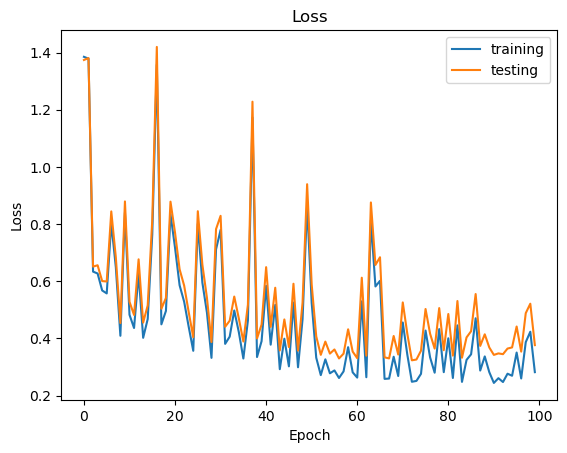

In [15]:
plot_since = 0
plt.plot(hist_train_loss[plot_since:], label = 'training')
plt.plot(hist_test_loss[plot_since:], label = 'testing')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')
plt.show()

### Guardar modelo

Cuidado de no reescribir

In [16]:
ruta_archivo = '.\modelos\pruebas_node_energy.pth'
#torch.save(model.state_dict(), ruta_archivo)

Cargar el modelo

In [17]:
#model = GCN_prueba(input_size = 20, hidden=30)
#model.load_state_dict(torch.load(ruta_archivo))

## Pruebas sobre los node features y la energia de vertices

Funcion para hacer pruebas,se toma un grafo y se ve la diferencia entre las energias de nodos y los ultimos node-features. La idea es hacer que sean lo mas iguales posibles. La hipotesis es que un modelo con arquitectura adecuada y entrenamietno correcto alcanzaria esto de manera automatica

In [18]:
def prediccion_energia_vertice(v, true = [], predicted = [], show = 0):
    # v- vector de un grafo 20 x 20
    
    # tomar el edge index
    edge_index = vector_to_edge_index(v)
    edge_index = torch.from_numpy(edge_index)
    
    # estos son los "features"
    x = np.eye(20)
    x = torch.from_numpy(x).float()
    
    # obtener la energia del grafo
    y = energia_from_vector(v)
    y = torch.tensor([[y]]).float()
    
    # poner el grafo en formato adecuado
    data = Data(x=x, edge_index=edge_index, y=y)
    
    # obtener los ultimos node features, de acuerdo al modelo
    with torch.no_grad():
        model.eval()
        _, node_features = model(x, edge_index, torch.tensor([0]))   
    node_features = node_features.numpy().T[0]
    
    # tomar la matriz de adyacencia del grafo
    matriz_adj = vector_to_matriz(v)
    adj = matriz_adj
    
    
    # obtener la energia de lo vertices, la real
    B = sqrtm(np.matmul(adj, adj.T))
    vector_energy = np.real(np.diagonal(B))
    
    # mostrar tanto los node features y la energia de vertices
    if show==1:
        print('Node Featuers')
        print(node_features)
        print('Node Energy')
        print(vector_energy)
    
    
    # se busca que sean iguales, ver la diferencia
    d = node_features - vector_energy
    d = [float(num) for num in d]
    
    
    # mostrar la diferencia
    if show == 1:
        print('Diferencia')
        print(np.array(d))
        print('Diferencia (absoluta) mayor: ', np.abs(np.array(d)).max())
        print('Diferencia (absoluta) promedio: ', np.abs(np.array(d)).mean())
    
    
    # Agregar la energia de vertices y los node features a las listas que se pasan
    # eso solo se hace si no hay valores nulos o infinitos en la energia de vertices
    if not (np.any(np.isnan(vector_energy)) or np.any(np.isinf(vector_energy))):
        true += list(vector_energy)
        predicted += list(node_features)
    
    
    # mostrar el grafo
    if show == 1:
        # redondear las diferencias para mostrarlas
        d = [round(num, 2) for num in d]
        
        # Crear el grafo
        G = nx.Graph()

        # Agregar nodos con etiquetas
        for idx in range(len(d)):
            G.add_node(idx+1, label=f"{d[idx]}")

        # Agregar aristas desde la matriz de adyacencia
        for i in range(len(adj)):
            for j in range(i+1, len(adj[i])):
                if adj[i][j] == 1:
                    G.add_edge(i+1, j+1)

        # Dibujar el grafo
        pos = nx.circular_layout(G)  # Posición de los nodo
        labels = nx.get_node_attributes(G, 'label')  # Obtener las etiquetas de los nodos

        # Configurar el estilo de los nodos
        node_size = 1000  # Tamaño de los nodos
        node_color = 'skyblue'  # Color de los nodos

        nx.draw_networkx(G, pos, with_labels=True, labels=labels, node_size=node_size, node_color=node_color, font_color='black')
        plt.axis("off")  # Ocultar los ejes
        plt.title('Suma : ' + str(round(sum(node_features), 2)) + '. Energia: ' + str(round(energia_from_matriz(adj), 2)))
        plt.show()
    
        # imprimir la suma de las energias de vertices
        # es decir, la energia del grafo
        print('Suma energia vertices: ',sum(vector_energy))
        
        # tambien imprimir la suma de los ultimos node features
        # es decir, la prediccion de energia del grafo
        print('Suma node features: ',sum(node_features))
        

Hacer la prueba en un grafo generado aleatoriamente

Node Featuers
[2.4281936 2.0724926 2.3500483 1.8674905 2.2053638 2.3665535 2.0041487
 2.1869035 2.0296528 1.5277638 2.2445667 2.546646  2.0266018 2.243011
 2.4620657 1.517875  2.0560133 2.0161529 1.8239613 1.8443432]
Node Energy
[2.57086958 1.94124843 2.4844515  1.68559872 2.232797   2.58698364
 1.84769967 2.30410849 2.10299088 1.18606877 2.29500565 2.57791382
 2.07684775 2.09295447 2.44468128 1.25447543 1.94359438 1.96730817
 1.74535697 1.85999223]
Diferencia
[-0.14267601  0.13124417 -0.1344032   0.18189181 -0.02743325 -0.22043009
  0.15644905 -0.11720501 -0.07333804  0.34169507 -0.05043898 -0.0312677
 -0.05024596  0.15005653  0.01738442  0.26339953  0.11241896  0.04884469
  0.07860428 -0.01564904]
Diferencia (absoluta) mayor:  0.3416950744651208
Diferencia (absoluta) promedio:  0.11725379053898848


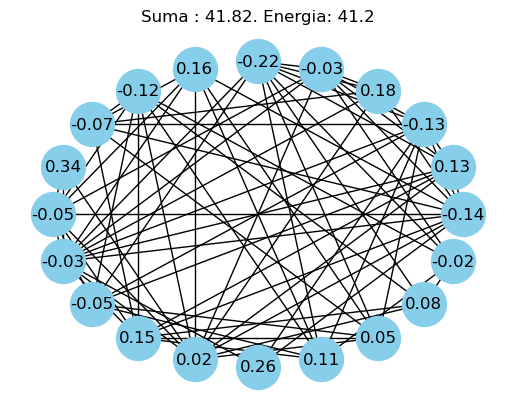

Suma energia vertices:  41.20094681966508
Suma node features:  41.81984806060791


In [19]:
values_l = [1, 1.5, 2, 3, 4, 5, 6, 8, 9]
values_p = [l/20 for l in values_l]

# tomar el argumento p para generar el grafo (erdos)
p = np.random.choice(values_p)

# hacer el vector del grafo con el parametro p seleccionado
v = np.random.choice([0, 1], size=(190), p = [1-p, p])

# hacer la prediccion
prediccion_energia_vertice(v, show = 1)

Hacer la prueba en un grafo del conjunto de entrenamiento

Node Featuers
[1.6719792 1.5508783 1.6748197 1.6559918 2.0267136 1.8056717 1.9658053
 1.9236042 1.8323185 1.7938962 1.9271221 1.9108791 2.0272305 1.448525
 1.666347  2.0786495 2.0137486 1.987498  1.9019506 1.9094458]
Node Energy
[1.50426802 1.51015905 1.61982786 1.47097894 2.06679446 1.72405038
 2.06608164 2.16017736 1.79767055 1.70790965 1.96886809 2.05181826
 2.13949287 1.19449545 1.61844047 2.23422521 2.29683255 2.09531507
 1.95505126 2.04451983]
Diferencia
[ 0.16771117  0.04071924  0.05499185  0.18501285 -0.04008085  0.08162132
 -0.10027635 -0.23657311  0.034648    0.08598655 -0.04174597 -0.14093912
 -0.11226237  0.2540295   0.04790656 -0.15557569 -0.2830839  -0.10781702
 -0.05310066 -0.13507407]
Diferencia (absoluta) mayor:  0.2830839012994466
Diferencia (absoluta) promedio:  0.1179578076221192


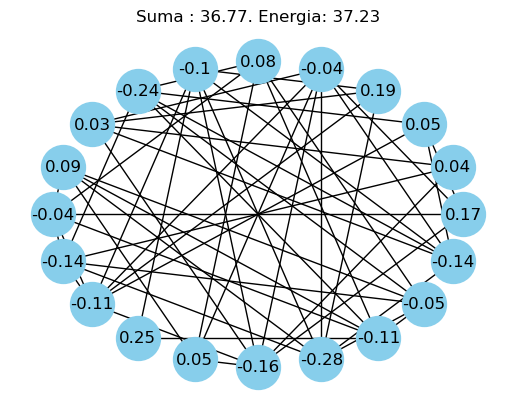

Suma energia vertices:  37.22697694872014
Suma node features:  36.77307486534119


In [20]:
# tomar un grafo aleatorio
idx = np.random.choice(division_train_test)
v = train_dataset.datos_grafos[idx]

# hacer la prediccion
prediccion_energia_vertice(v, show = 1)

Iterar en n grafos del conjunto de prueba, tomar la energia de nodo y los node-features, guardar estos valores. Ver si son parecidos.

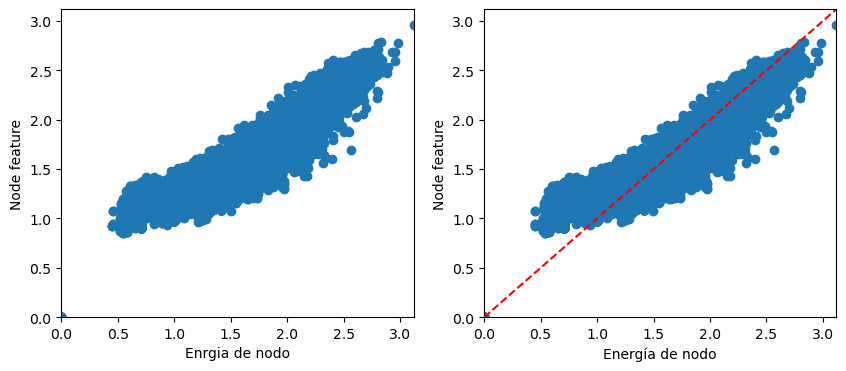

Pearson= 0.9580533650203784
MAE = 0.1525025863526061
MSE = 0.042166398628517496


In [21]:
n = 450

# tomar menos datos de los usados para entrenar
assert n<=division_train_test

# ir salvando los valores
true = []
predicted = []

# iterar en todos los grafos a considerar
for i in range(n):
    # tomar el grafo, ir en orden
    v = train_dataset.datos_grafos[i]
    # hacer las predicciones, pasar las listas para guardarlas
    prediccion_energia_vertice(v, true, predicted, show = 0)

    
# hacerlos array
true = np.array(true)
predicted = np.array(predicted)


# Configuración del gráfico
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4))


# graficar los datos
ax1.scatter(true, predicted)
ax1.set_xlabel('Enrgia de nodo')
ax1.set_ylabel('Node feature')

# graficar los datos
ax2.scatter(true, predicted)
ax2.set_xlabel('Energía de nodo')
ax2.set_ylabel('Node feature')


# Establecer misma escala en ambos ejes
max_value = max(max(true), max(predicted))
ax1.set_xlim([0, max_value])
ax1.set_ylim([0, max_value])
ax2.set_xlim([0, max_value])
ax2.set_ylim([0, max_value])

# Dibujar línea de identidad en el plot 2
identity_line = np.linspace(0, max_value, 100)
ax2.plot(identity_line, identity_line, color='r', linestyle='--')

# Mostrar el gráfico
plt.show()


# ver la correlacion de la energia de vertice y los node features
from scipy.stats import pearsonr
p = pearsonr(true, predicted).statistic
print('Pearson=', p)


# ver unas metricas de estos valores

ab = np.abs(true - predicted)
mae = np.mean(ab)
print('MAE =', mae)


mse = mean_squared_error(true, predicted)
print('MSE =', mse)